# Load data

In [74]:
import sys
sys.path.append('../flwrapp')

In [75]:
import datasets
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from dentalData.Pipelines import entire_data_processing_pipeline

In [76]:
ds = entire_data_processing_pipeline(sys.path[-1])

Data with two categories is imported
id QLQB
timestamp start 09-04-2025 22-08-28
timestamp end 
n_categories 2
original data size (5593, 98)
previous values no


c:\Users\Bruger\Desktop\BachelorProject---A-Federated-Learning-Approach-to-JIA\mlNotebooks\../flwrapp\dentalData\FeatureEngineering\RightLeftTransformation.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[featureNameMerged] = mergedList
c:\Users\Bruger\Desktop\BachelorProject---A-Federated-Learning-Approach-to-JIA\mlNotebooks\../flwrapp\dentalData\FeatureEngineering\RightLeftTransformation.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[featureNameMerged] = mergedList
c:\Users\Bruger\Desktop\BachelorProjec

Merging of features is done
encoding one hot
encoded data size (5593, 116)
Data encoded
Data normalized
data=      index  sex  ageatvisitation  difftdate  activity  morningstiffness  \
0         0    1        10.067077   0.000000         1                 0   
1         1    0         8.180698   0.000000         0                 0   
2         2    1         8.783025   0.000000         0                 0   
3         3    0         4.112252   0.000000         1                 0   
4         4    1         5.295003   0.000000         0                 0   
...     ...  ...              ...        ...       ...               ...   
5588   6000    1        16.689938  13.932923         1                 0   
5589   6001    1        16.134155  11.633128         0                 0   
5590   6003    1        17.719370  14.105407         0                 0   
5591   6005    1        17.817933  14.031485         0                 0   
5592   6010    1        17.092402  14.335387         0 

c:\Users\Bruger\Desktop\BachelorProject---A-Federated-Learning-Approach-to-JIA\.venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [77]:
X, y = np.array(ds['features']), np.array(ds['labels'])

# Convert labels to floats instead of int64
X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

In [78]:
def kFoldCrossValidationSplit(X, y, k = 5):
    # TODO: Maybe add shuffling before splitting
    segmentSize = X.shape[0] // k
    segmentations = []
    for i in range(k):
        start = i * segmentSize
        end = (i+1) * segmentSize
        segmentation = {
            "X_train": np.concatenate([X[:start, :], X[end:, :]]),
            "y_train": np.concatenate([y[:start], y[end:]]),
            "X_test": X[start:end],
            "y_test": y[start:end],
        }
        segmentations.append(segmentation)
    return segmentations
        
# Set k for the fold crossvalidation

k = 5

segmentations = kFoldCrossValidationSplit(X, y, k)

segmentations[0]["y_train"].shape

(4475,)

In [79]:
def createSubTrainsets(segmentations: list):
    splitSegmentations = []
    for segmentation in segmentations:
        train_len = segmentation["X_train"].shape[0]
        splitSegmentation = {
            "X_train_10p": segmentation["X_train"][:int(0.1*train_len)],
            "y_train_10p": segmentation["y_train"][:int(0.1*train_len)],
            "X_train_50p": segmentation["X_train"][:int(0.5*train_len)],
            "y_train_50p": segmentation["y_train"][:int(0.5*train_len)],
            "X_train_100p": segmentation["X_train"],
            "y_train_100p": segmentation["y_train"],
            "X_test_total": segmentation["X_test"],
            "y_test_total": segmentation["y_test"],
        }
        splitSegmentations.append(splitSegmentation)
    return splitSegmentations

splitSegmentations = createSubTrainsets(segmentations)

splitSegmentations[0]['X_train_10p'].shape, np.mean(splitSegmentations[0]['y_train_100p'])

((447, 115), np.float64(0.383463687150838))

# Define dmatrix for XGBoost

In [80]:
import xgboost as xgb

def convertToDMatrix(segmentation):
    dmatrix_train_10p = xgb.DMatrix(segmentation["X_train_10p"], label=segmentation["y_train_10p"], enable_categorical=True)
    dmatrix_train_50p = xgb.DMatrix(segmentation["X_train_50p"], label=segmentation["y_train_50p"], enable_categorical=True)
    dmatrix_train_100p = xgb.DMatrix(segmentation["X_train_100p"], label=segmentation["y_train_100p"], enable_categorical=True)

    dmatrix_test = xgb.DMatrix(segmentation["X_test_total"], label=segmentation["y_test_total"], enable_categorical=True)
    
    return {
        "dmatrix_train_10p": dmatrix_train_10p,
        "dmatrix_train_50p": dmatrix_train_50p,
        "dmatrix_train_100p": dmatrix_train_100p,
        "dmatrix_test": dmatrix_test
    }

dmatrixSegmentations = list(map(lambda x: convertToDMatrix(x), splitSegmentations))

dmatrixSegmentations

[{'dmatrix_train_10p': <xgboost.core.DMatrix at 0x1f2eab9f990>,
  'dmatrix_train_50p': <xgboost.core.DMatrix at 0x1f2eadf8090>,
  'dmatrix_train_100p': <xgboost.core.DMatrix at 0x1f2eae10b10>,
  'dmatrix_test': <xgboost.core.DMatrix at 0x1f2ea947f10>},
 {'dmatrix_train_10p': <xgboost.core.DMatrix at 0x1f2eae69d10>,
  'dmatrix_train_50p': <xgboost.core.DMatrix at 0x1f2eae6bfd0>,
  'dmatrix_train_100p': <xgboost.core.DMatrix at 0x1f2eabc43d0>,
  'dmatrix_test': <xgboost.core.DMatrix at 0x1f2eab9e190>},
 {'dmatrix_train_10p': <xgboost.core.DMatrix at 0x1f2eab9da90>,
  'dmatrix_train_50p': <xgboost.core.DMatrix at 0x1f2eac2c1d0>,
  'dmatrix_train_100p': <xgboost.core.DMatrix at 0x1f2eac2e610>,
  'dmatrix_test': <xgboost.core.DMatrix at 0x1f2eac2f010>},
 {'dmatrix_train_10p': <xgboost.core.DMatrix at 0x1f2eac2ff10>,
  'dmatrix_train_50p': <xgboost.core.DMatrix at 0x1f2eac2c190>,
  'dmatrix_train_100p': <xgboost.core.DMatrix at 0x1f2eac2ef10>,
  'dmatrix_test': <xgboost.core.DMatrix at 0x1f2

In [81]:
def createAndTrainModel(dmatrix_train, test_dmatrices, params, num_boost_round=50):
    bst = xgb.train(
        params,
        dmatrix_train,
        num_boost_round=1
    )
    evals = [[bst.eval(dmatrix_test, "Test", 0) for dmatrix_test in test_dmatrices.values()]]
    for i in range(1, num_boost_round):
        bst.update(dmatrix_train, i)
        evals.append([bst.eval(dmatrix_test, "Test", i) for dmatrix_test in test_dmatrices.values()])
    return bst, evals

In [82]:
params = {
    "objective": "binary:logistic",
    "eta": 0.1, 
    "max_depth": 8,
    "eval_metric":["error"],
    "nthread": 16,
    "num_parallel_tree": 1,
    "subsample": 1,
    "tree_method": "hist"
}

def trainModels(dmatrices, params):
    # Create dictionary of test matrices
    test_dmatrices = {
        "Global": dmatrices['dmatrix_test'],
    }
    bst_10p, evals_10p = createAndTrainModel(dmatrices['dmatrix_train_10p'], test_dmatrices, params)
    bst_50p, evals_50p = createAndTrainModel(dmatrices['dmatrix_train_50p'], test_dmatrices, params)
    bst_100p, evals_100p = createAndTrainModel(dmatrices['dmatrix_train_100p'], test_dmatrices, params)
    return {
        "bst_10p": bst_10p,
        "evals_10p": evals_10p,
        "bst_50p": bst_50p,
        "evals_50p": evals_50p,
        "bst_100p": bst_100p,
        "evals_100p": evals_100p,
    }

segmentationsResults = list(map(lambda x: trainModels(x, params), dmatrixSegmentations))

# Plot results from 10%-train

In [84]:
import matplotlib.pyplot as plt

def getValuesFromEvals(evals):
    values = np.array([[float(inner_eval.split(":")[1]) for inner_eval in inner_evals] for inner_evals in evals])
    # Put values into a dictionary
    return values[:, 0]

End of training 10% accuracy: 0.8141323792486583


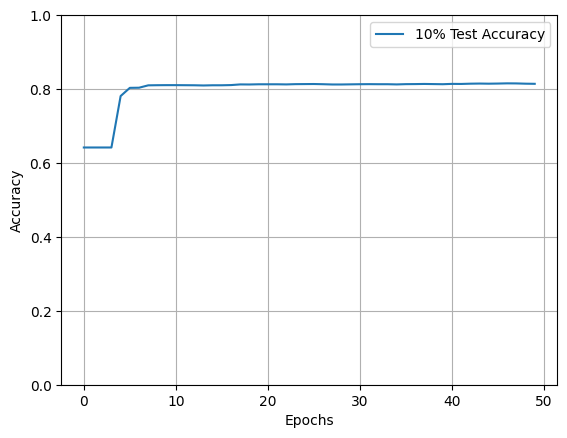

In [85]:
eval_values_10p = list(map(lambda x: getValuesFromEvals(x['evals_10p']), segmentationsResults))

eval_values_10pMEAN = np.mean(np.array(eval_values_10p), axis=0)

# Plot test accuracy
accuracy = 1 - np.array(eval_values_10pMEAN)
print(f"End of training 10% accuracy: {accuracy[-1]}")
plt.plot(accuracy, label=f'10% Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

### Confusion matrix

In [86]:
# Make a confusion matrix for the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Known to be true')
    plt.show()

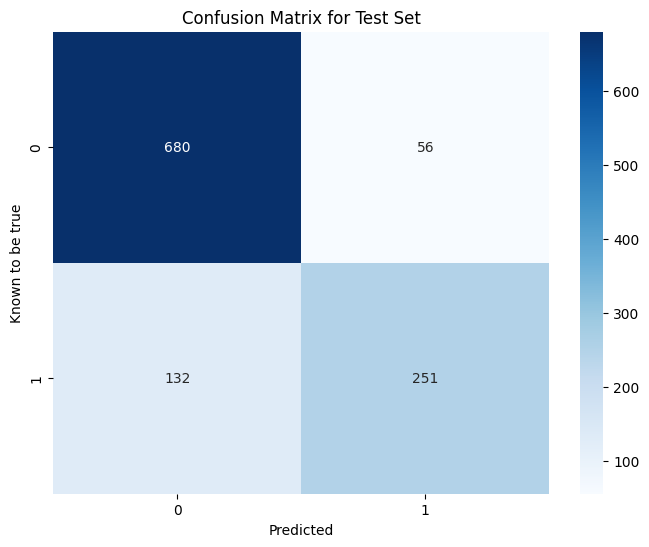

In [87]:
plot_confusion_matrix(y_test_total, bst_10p.predict(dmatrix_test) >= 0.5, title='Confusion Matrix for Test Set', labels=[0, 1])

# Plot results from 50%-train

End of training 50% accuracy: 0.8304114490161002


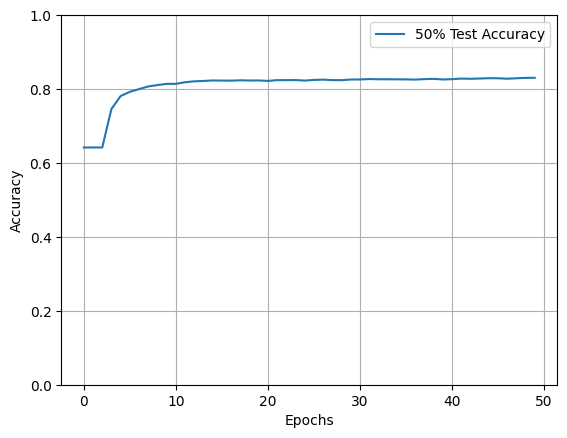

In [93]:
eval_values_50p = list(map(lambda x: getValuesFromEvals(x['evals_50p']), segmentationsResults))

eval_values_50pMEAN = np.mean(np.array(eval_values_50p), axis=0)

# Plot test accuracy
accuracy = 1 - np.array(eval_values_50pMEAN)
print(f"End of training 50% accuracy: {accuracy[-1]}")
plt.plot(accuracy, label=f'50% Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

### Confusion matrix

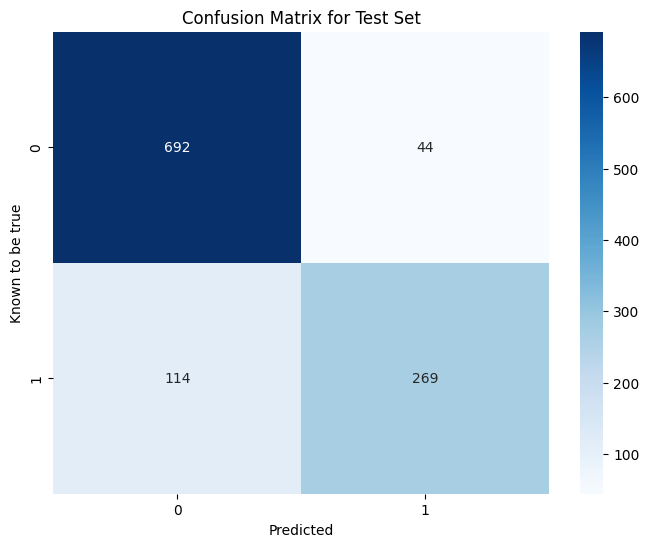

In [89]:
plot_confusion_matrix(y_test_total, bst_50p.predict(dmatrix_test) >= 0.5, title='Confusion Matrix for Test Set', labels=[0, 1])

# Plot results from 100%-train

End of training 100% accuracy: 0.8518783542039357


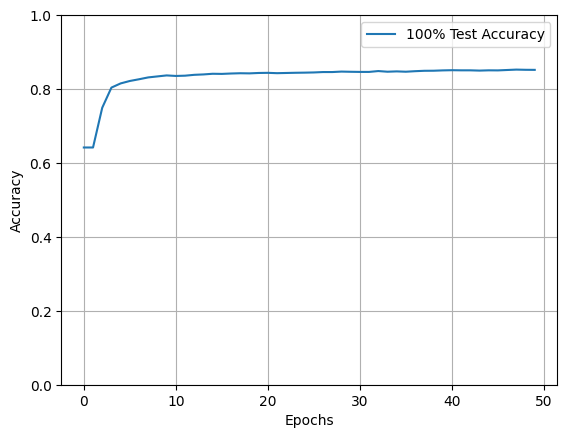

In [94]:
eval_values_100p = list(map(lambda x: getValuesFromEvals(x['evals_100p']), segmentationsResults))

eval_values_100pMEAN = np.mean(np.array(eval_values_100p), axis=0)

# Plot test accuracy
accuracy = 1 - np.array(eval_values_100pMEAN)
print(f"End of training 100% accuracy: {accuracy[-1]}")
plt.plot(accuracy, label=f'100% Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

### Confusion matrix

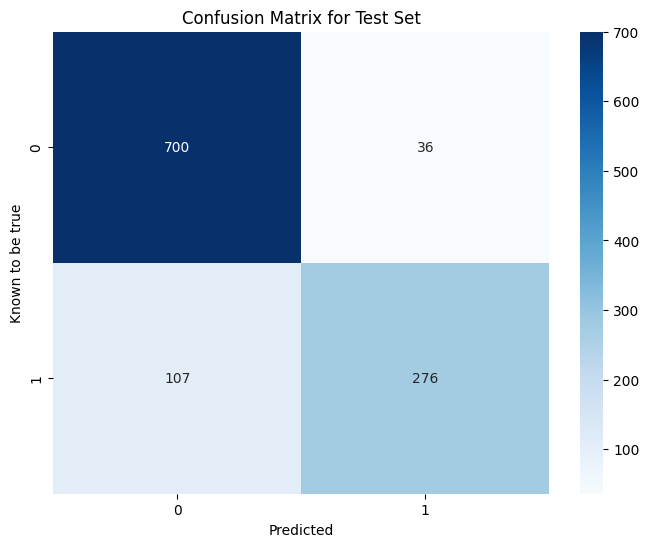

In [91]:
plot_confusion_matrix(y_test_total, bst_100p.predict(dmatrix_test) >= 0.5, title='Confusion Matrix for Test Set', labels=[0, 1])

# Plot of all accuracies

End of training 100% accuracy: 0.8518783542039357
End of training 50% accuracy: 0.8304114490161002
End of training 10% accuracy: 0.8141323792486583


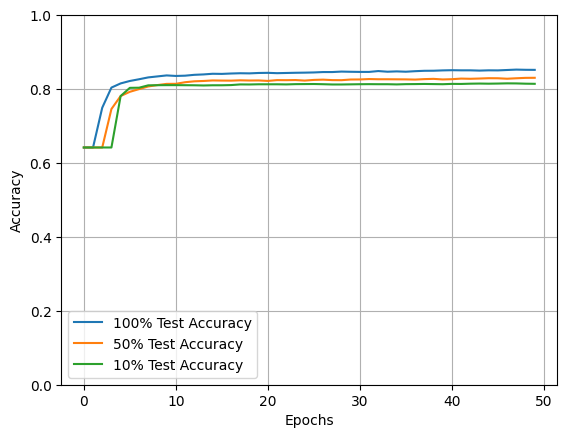

In [95]:
# Plot test accuracy
accuracy_100p = 1 - np.array(eval_values_100pMEAN)
accuracy_50p = 1 - np.array(eval_values_50pMEAN)
accuracy_10p = 1 - np.array(eval_values_10pMEAN)
print(f"End of training 100% accuracy: {accuracy_100p[-1]}")
print(f"End of training 50% accuracy: {accuracy_50p[-1]}")
print(f"End of training 10% accuracy: {accuracy_10p[-1]}")
plt.plot(accuracy_100p, label=f'100% Test Accuracy')
plt.plot(accuracy_50p, label=f'50% Test Accuracy')
plt.plot(accuracy_10p, label=f'10% Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()